# load libraries

In [1]:
import sys
import os 
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import nibabel as nib
import pandas as pd
import pickle 
from scipy.stats import zscore
import numpy as np
from sklearn.model_selection import KFold
from scipy.stats import pearsonr, binomtest
import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm
from scipy.stats import ttest_1samp
from statsmodels.stats.multitest import multipletests
from scipy.stats import wilcoxon
import h5py
import numpy as np
from scipy.stats import pearsonr
from joblib import Parallel, delayed
from tqdm import tqdm
import seaborn as sns
import logging
import time
import psutil
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

In [3]:
allRuns = [ 'test1_901', 'test2_1101', 'test3_1301', 'test4_1501', 'test5_1701', 'test6_1901', 'test7_2101', 'test8_2301']
nregions = 360
relevantConds = ['Practice_Cong_NEXT','Practice_Incong_NEXT', 'Novel_Cong_NEXT', 'Novel_Incong_NEXT']
networkmappings = {'vis1':1, 'vis2':2, 'smn':3,'con':4, 'dan':5,'lan':6,'fpn':7,'aud':8, 'dmn':9, 
                   'pmulti':10, 'vmm':11, 'ora':12}  
target_networks = list(networkmappings.values())
nnetworks = len(target_networks)

In [4]:
subjNums = [ 'sub-3', 'sub-4', 'sub-5', 'sub-6', 'sub-7', 'sub-8', 'sub-10', 
         'sub-11', 'sub-12', 'sub-13', 'sub-14', 'sub-15', 'sub-16', 'sub-17', 'sub-18', 'sub-19', 'sub-20',
           'sub-21', 'sub-22', 'sub-23', 'sub-24', 'sub-25', 'sub-26', 'sub-28', 'sub-29', 'sub-30',
          'sub-31', 'sub-32', 'sub-33', 'sub-34', 'sub-35', 'sub-36', 'sub-37', 'sub-38', 'sub-39', 'sub-40']

In [5]:
sys.path.append('/projects/f_mc1689_1/MeiranNext/docs/scripts/ArunScripts/ActflowTesting/')


In [6]:
actual_data_dir = '/projects/f_mc1689_1/MeiranNext/data/results/ArunResults/ActualBetasParcelwiseH5/'
actual_suffix = '_actualBetas.h5' 

pred_data_dir = '/projects/f_mc1689_1/MeiranNext/data/results/ArunResults/FCPermTestFoundIV/'
pred_suffix = '_PermPredBetas.h5'

In [7]:
networkpartition_dir = '/projects/f_mc1689_1/AnalysisTools/ActflowToolbox/dependencies/ColeAnticevicNetPartition/'
networkdef = np.loadtxt(networkpartition_dir + 'cortex_parcel_network_assignments.txt') #1 based 

# load actual betas

In [9]:
def LoadActualBetas(subj, input_network):
    """
    Loads trial-wise beta activations for left and right button presses
    from HDF5 files, grouped by the specified input network.

    Parameters
    ----------
    subj : str
        Subject identifier (used to locate the subject-specific .h5 file).
    input_network : int
        Index of the target network in the 'networkdef' array. Used to select relevant parcels.

    Returns
    -------
    ActualActivationVecLeft : array or None, shape (N, P)
        Beta activations for N left-press trials across P parcels in the input network.
    ActualActivationVecRight : array or None, shape (M, P)
        Beta activations for M right-press trials across P parcels in the input network.
    """
    ActualActivationVecLeft = []
    ActualActivationVecRight = []

    h5_path = actual_data_dir + subj + actual_suffix  # Full path to subject's .h5 file

    try:
        with h5py.File(h5_path, 'r') as h5f:
            for run in allRuns:
                # Skip missing runs
                if run not in h5f:
                    continue

                for miniblock_key in h5f[run]:
                    mb = h5f[run][miniblock_key]

                    # Skip miniblocks without motor response info
                    if 'motor_response' not in mb:
                        continue

                    # Load all conditions, betas, and motor responses for the miniblock
                    conditions = [c.decode('utf-8') for c in mb['condition']]
                    betas = mb['betas'][:]  # shape: (nTrials, nParcels)
                    motor_resp = [r.decode('utf-8') for r in mb['motor_response']]

                    # Loop over trials in this miniblock
                    for i, cond in enumerate(conditions):
                        if 'GO' in cond:
                            goBetas = betas[i].astype(np.float32, copy=False)
                            button = motor_resp[i]

                            # Validate dimensionality
                            if goBetas.shape[0] != len(networkdef):
                                raise ValueError("Mismatch between GO betas and networkdef dimensions.")

                            # Select only parcels belonging to the input network
                            input_mask = (networkdef == input_network)

                            # Append the beta vector to left/right list based on motor response
                            if button == 'left':
                                actVectLeft = goBetas[input_mask]
                                if actVectLeft.size > 0:
                                    ActualActivationVecLeft.append(actVectLeft)

                            elif button == 'right':
                                actVectRight = goBetas[input_mask]
                                if actVectRight.size > 0:
                                    ActualActivationVecRight.append(actVectRight)

    except Exception as e:
        logging.error(f"Failed to process subject {subj} in LoadActualBetas: {e}")

    # Stack trial-wise activations into (nTrials, nParcels) or return None if empty
    ActualActivationVecLeft = np.vstack(ActualActivationVecLeft) if ActualActivationVecLeft else None
    ActualActivationVecRight = np.vstack(ActualActivationVecRight) if ActualActivationVecRight else None

    return ActualActivationVecLeft, ActualActivationVecRight


# load permuted betas

In [10]:
def loadPermutedBetas(subj, iter, input_network):
    """
    Loads permuted predicted betas for a given subject and iteration,
    and separates them into left and right trials based on motor responses.

    Parameters
    ----------
    subj : str
        Subject identifier.
    iter : int
        Permutation index to select from the predicted beta array.
    input_network : int
        Index of the target network used to mask relevant parcels.

    Returns
    -------
    left : np.ndarray
        Array of permuted predicted betas for left trials, shape (nLeftTrials, nParcels).
    right : np.ndarray
        Array of permuted predicted betas for right trials, shape (nRightTrials, nParcels).
        Returns (None, None) if loading fails.
    """
    # Construct paths for permuted predicted betas and actual HDF5 data
    pred_path = os.path.join(pred_data_dir, subj, f"{subj}_PermPredBetas.h5")
    actual_path = os.path.join(actual_data_dir, subj + actual_suffix)

    try:
        # Load permuted predicted betas for the specified iteration
        with h5py.File(pred_path, 'r') as f:
            pred_betas = f['PermutedBetas'][:, :, iter]  # shape: (nTrials, nNodes)

        # Load corresponding motor responses from the actual data
        motor_responses = []
        with h5py.File(actual_path, 'r') as f_actual:
            for run in allRuns:
                if run not in f_actual:
                    continue

                for miniblock_key in f_actual[run]:
                    mb = f_actual[run][miniblock_key]

                    # Skip miniblocks that lack motor response info
                    if 'motor_response' not in mb:
                        continue

                    # Decode conditions and motor responses
                    conditions = [c.decode('utf-8') for c in mb['condition']]
                    motor_resp = [r.decode('utf-8') for r in mb['motor_response']]

                    # Store motor responses only for GO trials
                    for cond, resp in zip(conditions, motor_resp):
                        if 'GO' in cond:
                            motor_responses.append(resp)

        # Filter the predicted betas using the input network mask
        input_mask = (networkdef == input_network)
        left, right = [], []

        # Group betas by motor response type
        for i, resp in enumerate(motor_responses):
            beta = pred_betas[i, input_mask]
            if resp == 'left':
                left.append(beta)
            elif resp == 'right':
                right.append(beta)

        return np.array(left), np.array(right)

    except Exception as e:
        # Return None if file not found or parsing fails
        # logging.error(f"Error loading permuted betas for {subj}, iter {iter}: {e}")
        return None, None


# load non permuted betas

In [11]:
def loadNonPermutedBetas(subj, input_network):
    """
    Loads non-permuted predicted betas for a given subject,
    and separates them into left and right trials based on motor responses.

    Parameters
    ----------
    subj : str
        Subject identifier.
    input_network : int
        Index of the target network used to mask relevant parcels.

    Returns
    -------
    left : np.ndarray
        Predicted betas for left-press trials, shape (nLeftTrials, nParcels).
    right : np.ndarray
        Predicted betas for right-press trials, shape (nRightTrials, nParcels).
        Returns (None, None) if loading fails.
    """
    # Define paths to predicted and actual activation data
    pred_path = os.path.join(pred_data_dir, subj, f"{subj}_PermPredBetas.h5")
    actual_path = os.path.join(actual_data_dir, subj + actual_suffix)

    try:
        # Load non-permuted predicted betas
        with h5py.File(pred_path, 'r') as f:
            pred_betas = f['NonPermutedBetas'][:]  # shape: (nTrials, nNodes)

        # Collect motor responses from actual data
        motor_responses = []
        with h5py.File(actual_path, 'r') as f_actual:
            for run in allRuns:
                if run not in f_actual:
                    continue

                for miniblock_key in f_actual[run]:
                    mb = f_actual[run][miniblock_key]

                    # Skip miniblocks without motor response information
                    if 'motor_response' not in mb:
                        continue

                    conditions = [c.decode('utf-8') for c in mb['condition']]
                    motor_resp = [r.decode('utf-8') for r in mb['motor_response']]

                    # Append motor responses for GO trials only
                    for cond, resp in zip(conditions, motor_resp):
                        if 'GO' in cond:
                            motor_responses.append(resp)

        # Sanity check: Ensure predicted betas and responses match in trial count
        if len(motor_responses) != pred_betas.shape[0]:
            raise ValueError(
                f"[{subj}] Mismatch: {len(motor_responses)} responses vs {pred_betas.shape[0]} predicted betas"
            )

        # Create network mask and separate betas by motor response
        input_mask = (networkdef == input_network)
        left, right = [], []

        for i, resp in enumerate(motor_responses):
            beta = pred_betas[i, input_mask]
            if resp == 'left':
                left.append(beta)
            elif resp == 'right':
                right.append(beta)

        return np.array(left), np.array(right)

    except Exception as e:
        # Return None if any error occurs during file read or processing
        # logging.error(f"Error loading non-permuted betas for {subj}: {e}")
        return None, None


# Non permuted accuracies 

In [12]:
def CVcorrNonPermuted(subj, input_network):
    """
    Performs 5-fold cross-validation to classify predicted betas (non-permuted)
    using templates from actual betas. Tests generalization of learned patterns
    from actual data to predicted data.

    Parameters
    ----------
    subj : str
        Subject identifier.
    input_network : int
        Index of the target network used for parcel selection.

    Returns
    -------
    float
        Mean classification accuracy across folds.
        Returns np.nan if data is missing or mismatched.
    """
    # Load actual and predicted (non-permuted) beta activations
    actual_left, actual_right = LoadActualBetas(subj, input_network)
    pred_left, pred_right = loadNonPermutedBetas(subj, input_network)

    # Handle missing data
    if actual_left is None or actual_right is None or pred_left is None or pred_right is None:
        return np.nan

    # Combine left/right trials and create labels
    X_actual = np.concatenate((actual_left, actual_right), axis=0)
    X_pred = np.concatenate((pred_left, pred_right), axis=0)
    y = np.array(['L'] * len(actual_left) + ['R'] * len(actual_right))

    # Set up 5-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []

    # Train on actual, test on predicted
    for train_idx, test_idx in kf.split(X_actual):
        X_train, y_train = X_actual[train_idx], y[train_idx]
        X_test, y_test = X_pred[test_idx], y[test_idx]

        # Compute mean templates from actual training data
        template_left = X_train[y_train == 'L'].mean(axis=0)
        template_right = X_train[y_train == 'R'].mean(axis=0)

        # Classify predicted test data based on correlation with templates
        decode = []
        for x in X_test:
            r_left = np.corrcoef(x, template_left)[0, 1]
            r_right = np.corrcoef(x, template_right)[0, 1]
            decode.append('L' if r_left > r_right else 'R')

        # Accuracy for this fold
        acc = np.mean(np.array(decode) == y_test)
        cv_scores.append(acc)

    # Return average accuracy across folds
    return np.mean(cv_scores)


In [13]:
def run_nonpermuted_for_subj(subj):
    """
    Runs cross-validated decoding for non-permuted predicted betas
    across all networks for a given subject.

    Parameters
    ----------
    subj : str
        Subject identifier.

    Returns
    -------
    list of float
        Decoding accuracy for each network for the given subject.
        Each element is the result of CVcorrNonPermuted().
    """
    return [
        CVcorrNonPermuted(subj, network_id)
        for network_id in networkmappings.values()
    ]


# Run the above function in parallel for all subjects
non_permuted_pred_accuracy = Parallel(n_jobs=-1)(
    delayed(run_nonpermuted_for_subj)(subj) for subj in tqdm(subjNums)
)

# Convert the list of lists into a NumPy array of shape (nSubjects, nNetworks)
non_permuted_pred_accuracy = np.array(non_permuted_pred_accuracy)


100%|██████████| 36/36 [00:00<00:00, 111.80it/s]


# Permuted accuracies

In [14]:
def CVcorrPermuted(subj, input_network, iter):
    """
    Performs 5-fold cross-validation to classify permuted predicted betas
    using templates derived from actual betas. Evaluates decoding performance
    of permuted models relative to actual ground truth.

    Parameters
    ----------
    subj : str
        Subject identifier.
    input_network : int
        Network index used for parcel selection.
    iter : int
        Permutation iteration index (used to select which permuted prediction to test).

    Returns
    -------
    float
        Mean classification accuracy across folds.
        Returns np.nan if data is missing or invalid.
    """
    # Load actual betas and permuted predicted betas for the given subject and network
    actual_left, actual_right = LoadActualBetas(subj, input_network)
    pred_left, pred_right = loadPermutedBetas(subj, iter, input_network)

    # If any data is missing, return NaN
    if actual_left is None or actual_right is None or pred_left is None or pred_right is None:
        return np.nan

    # Stack left and right trials together, and create labels
    X_actual = np.concatenate((actual_left, actual_right), axis=0)
    X_pred = np.concatenate((pred_left, pred_right), axis=0)
    y = np.array(['L'] * len(actual_left) + ['R'] * len(actual_right))

    # Set up 5-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []

    # For each fold, train on actual, test on permuted predicted
    for train_idx, test_idx in kf.split(X_actual):
        X_train, y_train = X_actual[train_idx], y[train_idx]
        X_test, y_test = X_pred[test_idx], y[test_idx]

        # Compute mean activation templates from training set
        template_left = X_train[y_train == 'L'].mean(axis=0)
        template_right = X_train[y_train == 'R'].mean(axis=0)

        # Classify each permuted test trial by comparing to templates
        decode = []
        for x in X_test:
            r_left = np.corrcoef(x, template_left)[0, 1]
            r_right = np.corrcoef(x, template_right)[0, 1]
            decode.append('L' if r_left > r_right else 'R')

        # Calculate accuracy for this fold
        acc = np.mean(np.array(decode) == y_test)
        cv_scores.append(acc)

    # Return average accuracy across folds
    return np.mean(cv_scores)


In [15]:
nPerms = 1000  # Number of permutation iterations


def run_permuted_single(subj, subj_idx, net_id, net_idx, iter):
    """
    Runs a single permutation decoding job for one subject, one network, and one permutation iteration.

    Parameters
    ----------
    subj : str
        Subject identifier.
    subj_idx : int
        Index of the subject (for placement in result array).
    net_id : int
        ID/index of the network (used for masking).
    net_idx : int
        Index of the network in the result array.
    iter : int
        Permutation iteration number.

    Returns
    -------
    tuple
        (subj_idx, net_idx, iter, accuracy) for storage in the final array.
    """
    acc = CVcorrPermuted(subj, net_id, iter)
    return (subj_idx, net_idx, iter, acc)


# 1. Create job list: all combinations of subjects, networks, and permutations
jobs = []
for subj_idx, subj in enumerate(subjNums):
    for net_idx, (net_name, net_id) in enumerate(networkmappings.items()):
        for i in range(nPerms):
            jobs.append((subj, subj_idx, net_id, net_idx, i))

# 2. Run all jobs in parallel
results = Parallel(n_jobs=-1)(
    delayed(run_permuted_single)(*job) for job in tqdm(jobs)
)

# 3. Allocate results into final 3D array: shape (nSubjects, nNetworks, nPerms)
permuted_pred_accuracies = np.zeros((len(subjNums), len(networkmappings), nPerms))

for subj_idx, net_idx, i, acc in results:
    permuted_pred_accuracies[subj_idx, net_idx, i] = acc


100%|██████████| 432000/432000 [1:29:58<00:00, 80.02it/s]


# compute non-permuted accuracy t-value

In [18]:
null_mean = 0.5  # Chance level
t_obs, _ = ttest_1samp(non_permuted_pred_accuracy, popmean=null_mean, axis=0)  # shape: (nNetworks,)

In [19]:
t_obs

array([ 1.17548170e+00,  4.17451128e-01,  3.08096399e+00, -2.40790638e-03,
       -1.17818721e+00, -9.54381330e-01,  9.10684420e-01, -8.25330637e-01,
       -1.76887429e+00,  1.86038093e+00,  9.75252951e-01,  1.95179785e-01])

# build null t-distribution

In [20]:
nPerms = permuted_pred_accuracies.shape[2]
nNetworks = permuted_pred_accuracies.shape[1]

t_perm = np.zeros((nPerms, nNetworks))

for i in range(nPerms):
    perm_data = permuted_pred_accuracies[:, :, i]  # shape: (nSubjs, nNetworks)
    t_vals, _ = ttest_1samp(perm_data, popmean=null_mean, axis=0)
    t_perm[i, :] = t_vals

# Max-T for each permutation
maxT_dist = np.max(t_perm, axis=1)  # shape: (nPerms,)


# compute threshold and p-value

In [21]:
alpha = 0.05
threshold = np.percentile(maxT_dist, 100 * (1 - alpha))  # upper 5% cutoff

# Compare observed t-values to max-T threshold
significant = t_obs > threshold  # boolean array of shape (nNetworks,)

# Get FWE-corrected p-values using empirical CDF
from statsmodels.distributions.empirical_distribution import ECDF
ecdf = ECDF(maxT_dist)
p_fwe = 1.0 - ecdf(t_obs)


In [27]:
p_fwe

array([0.812, 0.991, 0.021, 1.   , 1.   , 1.   , 0.912, 1.   , 1.   ,
       0.366, 0.886, 1.   ])

In [22]:
significant

array([False, False,  True, False, False, False, False, False, False,
       False, False, False])

# histogram plot networkwise

In [31]:
def plot_null_with_observed(maxT_dist, actual_t, network_name):
    """
    Plots the MaxT null distribution with the observed t-statistic overlaid
    for a specific network.

    Parameters
    ----------
    maxT_dist : array_like
        Null distribution of maximum t-statistics (e.g., from permutation test).
    actual_t : float
        Observed t-statistic for the network.
    network_name : str
        Name of the network (used in plot title and filename).
    """
    plt.figure(figsize=(8, 5))
    
    # Plot histogram of the null distribution
    plt.hist(maxT_dist, bins=100, color='skyblue', label='Null distribution')
    
    # Add a vertical line for the observed t-value
    plt.axvline(actual_t, color='red', linestyle='--', linewidth=2,
                label=f'Observed t = {actual_t:.2f}')
    
    # Plot formatting
    plt.title(f'MaxT Null Distribution\n{network_name} network', fontsize=14)
    plt.xlabel('T-value', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend()
    plt.tight_layout()
    
    # Save and show the figure
    plt.savefig(f"FCshuffledplot_{network_name}.svg", bbox_inches="tight")
    plt.show()


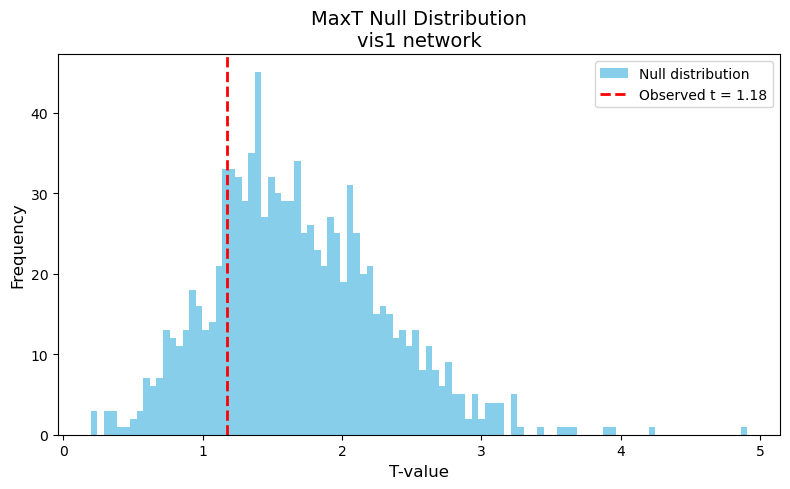

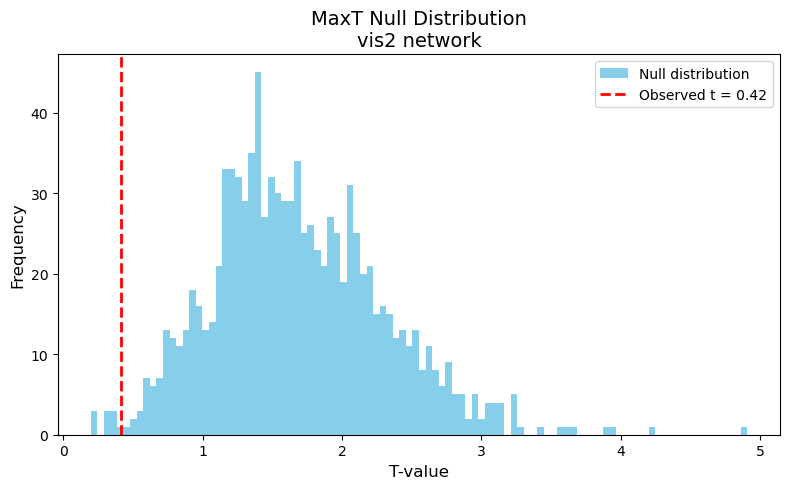

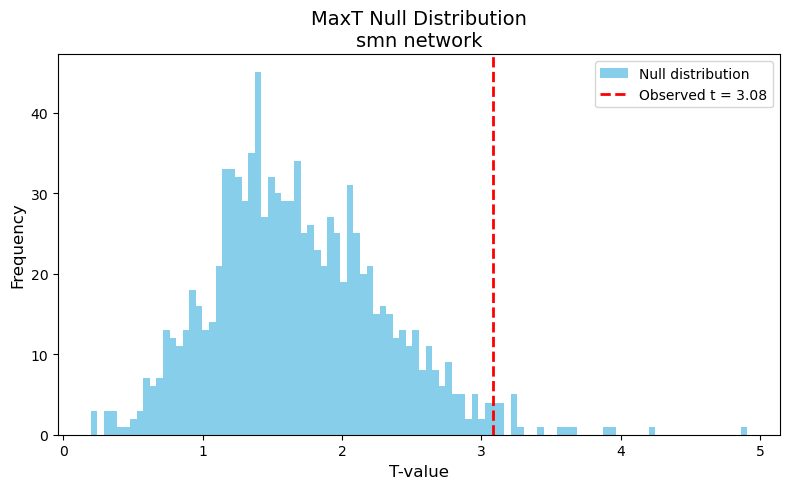

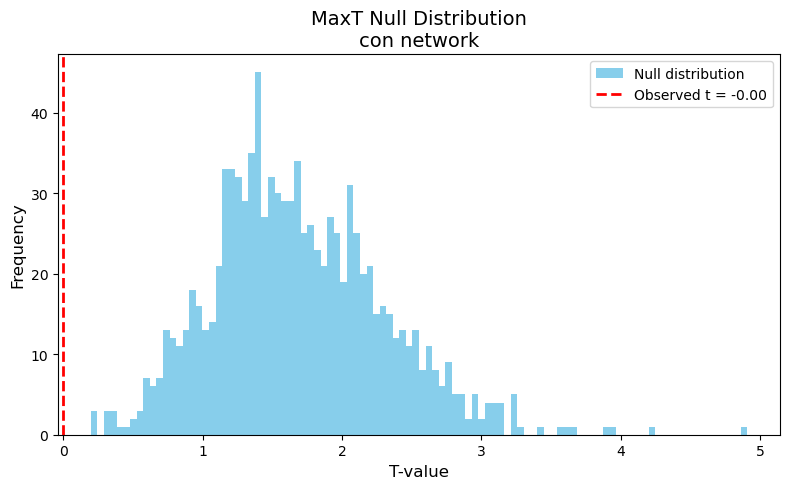

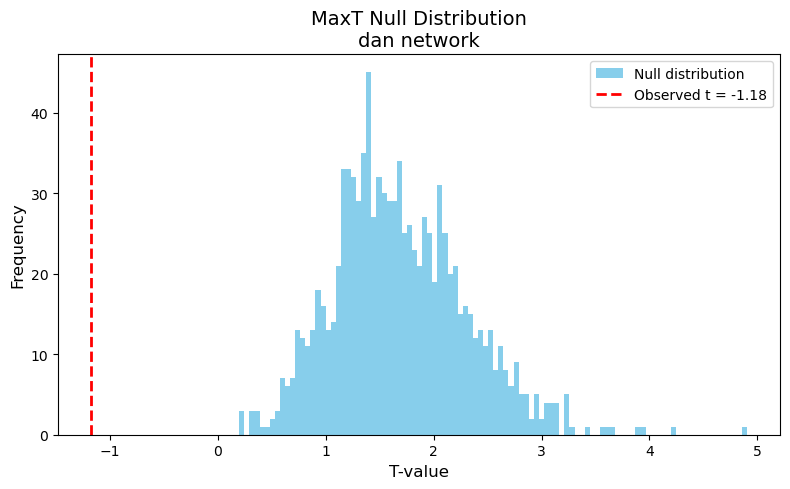

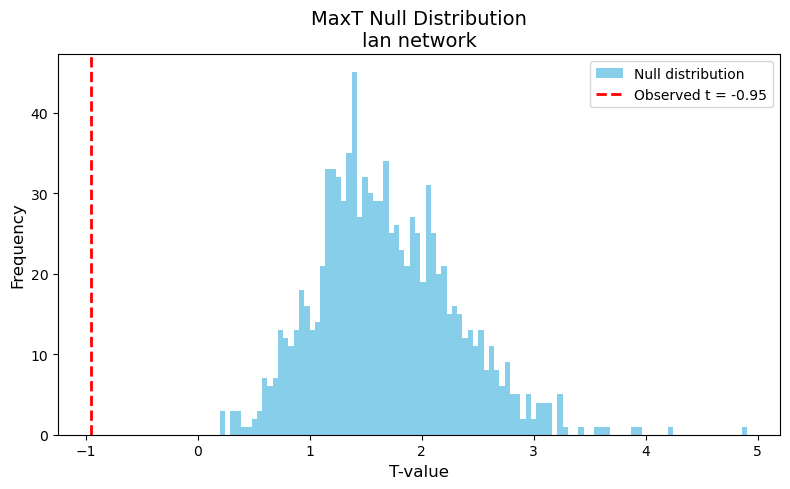

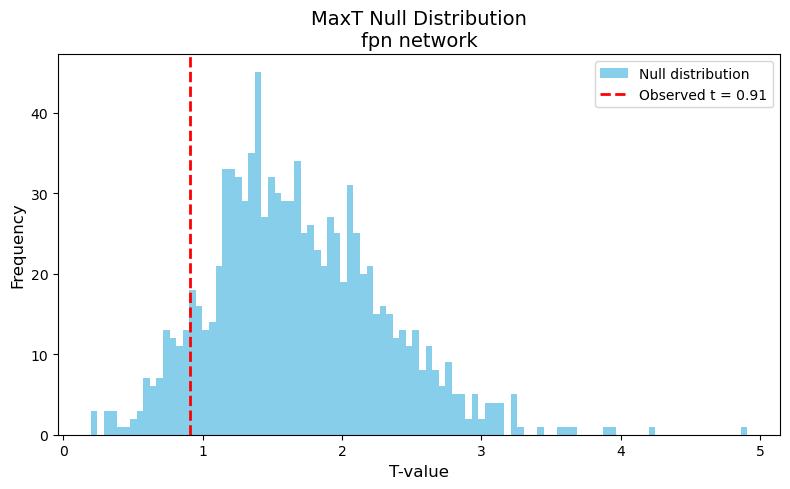

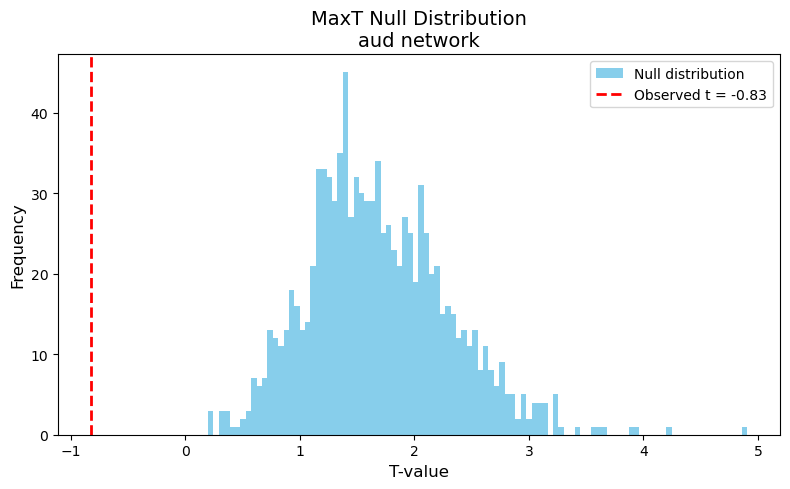

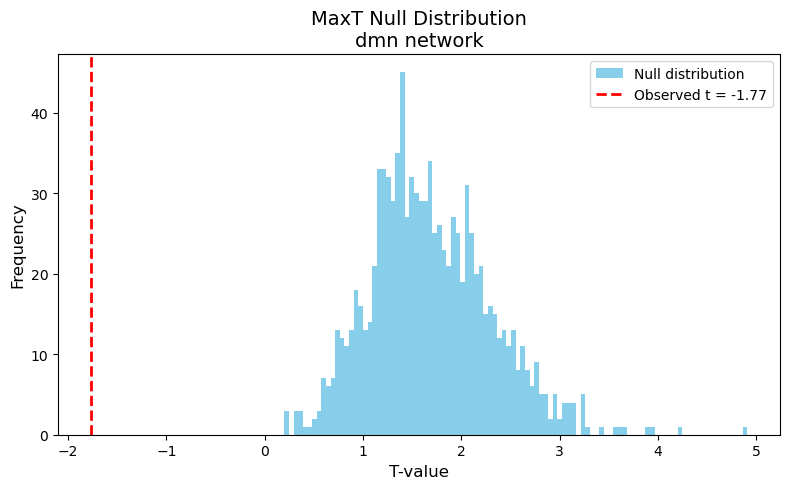

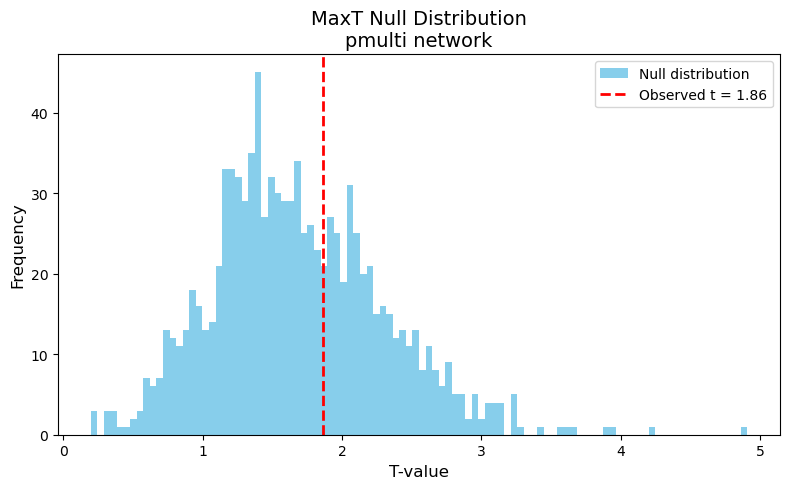

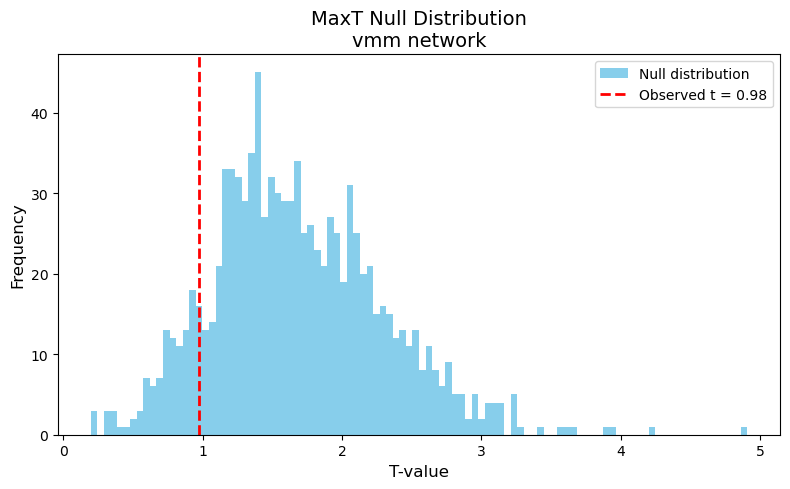

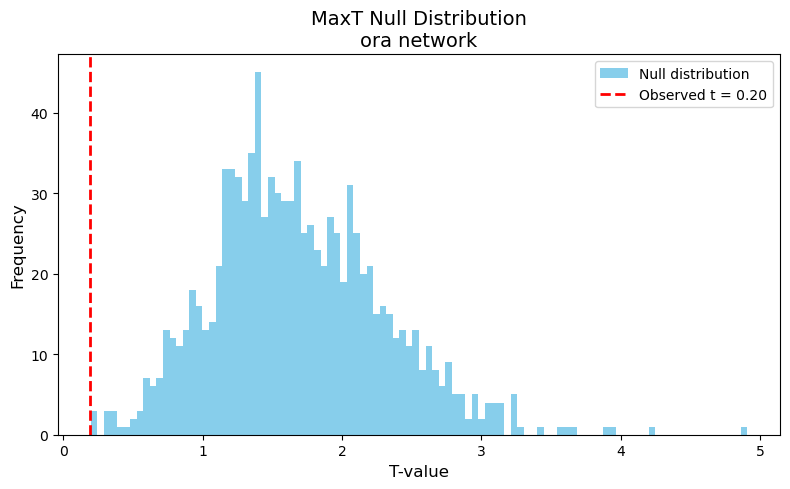

In [32]:
# Loop through each target network and plot null vs. observed t-stat
for i in target_networks:
    network_index = i
    network_name = list(networkmappings.keys())[network_index]  # Get network name by index
    actual_t = t_obs[network_index]  # Get the observed t-stat for this network

    # Generate plot comparing null distribution to observed t-value
    plot_null_with_observed(maxT_dist, actual_t, network_name)
